## Challenge

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

* Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

* First, load the dataset.

* Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

* Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

* In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

* Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

###### showing all rows and columns 
- pd.set_option('display.max_columns', 500)
- pd.set_option('display.max_rows', 500)

### check code before submission
http://pep8online.com/

In [13]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats.mstats import winsorize


from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox

# These two lines let you show all the columns and rows
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

warnings.filterwarnings('ignore')

In [14]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

In [15]:
### query the data and load the data
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

### Analyze data: missing values?
* Detect the problems with the data such as missing values and outliers. 
* Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. 

In [16]:
### take a look at the data and see what format they are
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [17]:
df.head(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [18]:
### Detect the problems with the data such as missing values and outliers.
## Do we have any missing values?
# Looks like nothing is more than 50% so we don't need to drop any columns
df.isnull().sum()*100/df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

##### Looks like we have some missing values - so we have to figure out how to handle missing values

In [11]:
#df['Hepatitis B'] = df.fillna(df['Hepatitis B'].mean())
#df['Hepatitis B'] = df.fillna(df['Hepatitis B'].mean())

In [36]:
## lets find the median of each of those columns that has null and we will use
# the median to replace the null values. 

mean = df.filter(["Life expectancy ","Adult Mortality", "Alcohol", "Hepatitis B"," BMI ","Polio","Total expenditure","Diphtheria ","GDP","Population"," thinness  1-19 years"," thinness 5-9 years","Income composition of resources","Schooling"]).mean()

# check to see how the median looks
print (mean)


Life expectancy                    7.582389e+01
Adult Mortality                    1.710701e+02
Alcohol                            1.368898e+02
Hepatitis B                        4.436579e+02
 BMI                               6.111535e+01
Polio                              9.500204e+01
Total expenditure                  1.599429e+02
Diphtheria                         9.477740e+01
GDP                                6.648281e+03
Population                         9.923596e+06
 thinness  1-19 years              2.802127e+01
 thinness 5-9 years                2.805153e+01
Income composition of resources    1.147294e+02
Schooling                          1.227311e+02
dtype: float64


In [37]:
## take care of the nulls using the median
cols = ["Life expectancy ","Adult Mortality","Alcohol", "Hepatitis B"," BMI ","Polio","Total expenditure","Diphtheria ","GDP","Population"," thinness  1-19 years"," thinness 5-9 years","Income composition of resources","Schooling"]
df[cols]=df[cols].fillna(df.mean().iloc[0])

In [38]:
## check to see how the null looks like now - should all be taken care of
df.isnull().sum()*100/df.isnull().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
 BMI                               0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
 HIV/AIDS                          0.0
GDP                                0.0
Population                         0.0
 thinness  1-19 years              0.0
 thinness 5-9 years                0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

### Outliers: 
* Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [57]:
#df1 = df.select_dtypes([np.int, np.float])
#for i, col in enumerate(df1.columns):
   # plt.figure(i)
# sns.distplot(df1[col])

In [68]:
#fig, axes = plt.subplots(ncols=len(df.columns), figsize=(10,5))
#for col, ax in zip(df, axes):
    #plt.subplot(6, 6, i)
    #df[col].value_counts().sort_index().plot.bar(ax=ax, title=col)

#plt.tight_layout()    
#plt.show()

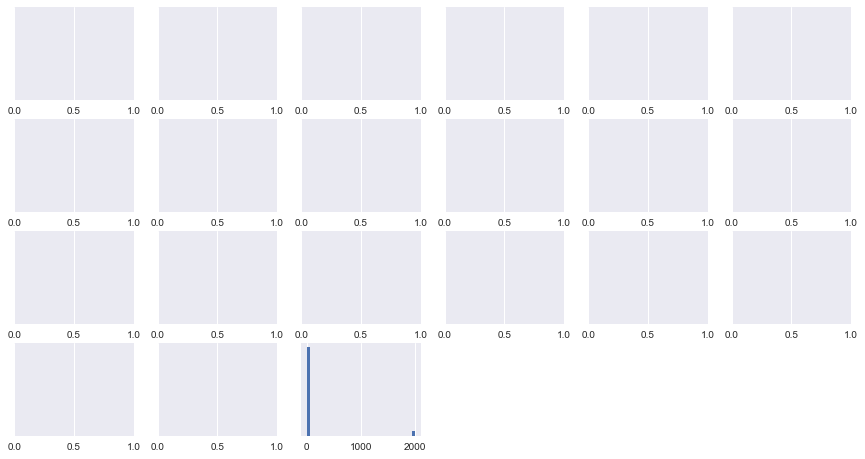

In [56]:
fig = plt.figure(figsize=(15, 12))
for i in range(1, df.shape[1]):
    plt.subplot(6, 6, i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    # f.axes.set_ylim([0, train.shape[0]])

    vals = np.size(df.iloc[:, i].unique())
    if vals < 10:
        bins = vals
    else:
        vals = 10

plt.hist(df.iloc[:, i], bins=30)
plt.show()

In [60]:
# df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
# this is a way to remove outliers but only for numerical ones - 
# what about non numberical ones?

In [64]:
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,75.823894,171.070116,30.303948,136.889806,738.251295,443.657931,2419.592240,61.115351,42.035739,95.002042,159.942944,94.777400,1.742103,6648.280663,9.923596e+06,28.021273,28.051532,114.729389,122.731110
std,4.613841,113.336196,164.085748,117.926501,497.617390,1987.914858,753.735735,11467.272489,211.635803,160.445548,156.121119,533.584332,156.182365,5.077785,13283.482661,5.407578e+07,214.322079,214.320631,464.864766,457.004642
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.200000,74.000000,0.000000,1.092500,4.685343,82.000000,0.000000,19.400000,0.000000,78.000000,4.370000,78.000000,0.100000,580.486996,5.874250e+03,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.100000,144.000000,3.000000,4.160000,64.912906,95.000000,17.000000,43.900000,4.000000,93.000000,5.950000,93.000000,0.100000,2008.000000,5.393575e+05,3.400000,3.400000,0.689500,12.500000
75%,2012.000000,75.700000,228.000000,22.000000,8.772500,441.534144,99.000000,360.250000,56.475000,28.000000,97.000000,8.190000,97.000000,0.800000,4779.405190,4.584371e+06,7.300000,7.300000,0.797000,14.700000
max,2015.000000,2008.000000,2008.000000,1800.000000,2008.000000,19479.911610,2008.000000,212183.000000,2008.000000,2500.000000,2008.000000,2008.000000,2008.000000,50.600000,119172.741800,1.293859e+09,2008.000000,2008.000000,2008.000000,2008.000000


In [66]:
df2 = df.copy()
def drop_numerical_outliers(df2, z_thresh=3):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df2.select_dtypes(include=[np.number]).apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, reduce=False).all(axis=1)
    # Drop (inplace) values set to be rejected
    df2.drop(df2.index[~constrains], inplace=True)

drop_numerical_outliers(df2)

In [70]:
#df2.describe(include = 'all')
df2.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2.305000e+03,2305.000000,2305.000000,2305.000000,2305.000000
mean,2007.023427,69.550542,156.923644,16.226464,4.369471,516.884258,408.429501,1030.466811,38.333145,22.570499,82.976139,5.817371,82.836443,1.098482,4926.122094,6.379043e+06,4.761215,4.803774,0.623234,11.965683
std,4.336374,8.552444,107.751918,37.378877,3.973761,1062.901400,723.472315,3410.660542,19.796337,51.243753,23.053547,2.304727,23.405092,2.439916,8214.692618,1.659095e+07,4.109946,4.188654,0.207258,3.160977
min,2000.000000,39.000000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2003.000000,64.200000,76.000000,0.000000,0.640000,16.887351,83.000000,0.000000,19.000000,0.000000,78.000000,4.260000,79.000000,0.100000,519.292285,1.578200e+04,1.700000,1.700000,0.494000,10.200000
50%,2007.000000,72.200000,144.000000,3.000000,3.530000,94.434457,95.000000,10.000000,44.200000,3.000000,93.000000,5.660000,93.000000,0.100000,2008.000000,5.959620e+05,3.400000,3.400000,0.678000,12.300000
75%,2011.000000,75.200000,221.000000,16.000000,7.250000,472.304703,99.000000,272.000000,55.700000,21.000000,97.000000,7.320000,97.000000,0.600000,4657.323610,4.255689e+06,7.100000,7.200000,0.770000,14.100000
max,2015.000000,89.000000,593.000000,377.000000,17.870000,6664.148708,2008.000000,35558.000000,77.100000,483.000000,99.000000,14.390000,99.000000,16.900000,46256.471600,1.575713e+08,22.000000,22.400000,0.945000,20.700000


### Data exploration
* Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

- Other than the country all other valriables are continuous - so a heatmap could be used to see numerical values and the correlation between other valriables and life expectancy which is our target variable.

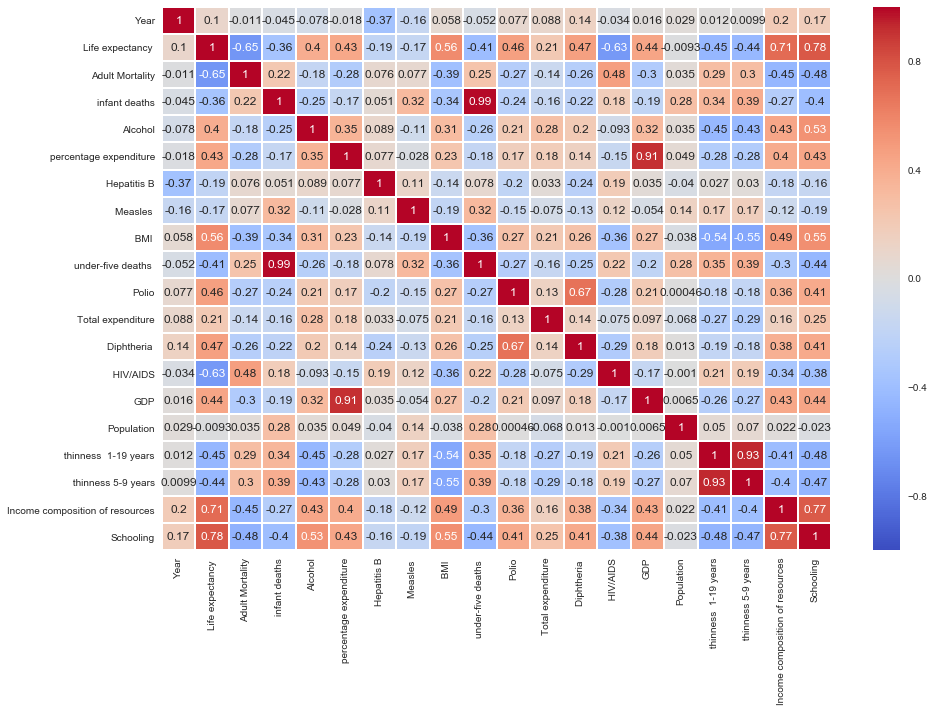

In [87]:
plt.figure(figsize=(30,20))
plt.subplots(figsize=(15, 10))
#sns.heatmap(df2.select_dtypes(include = ['number']).corr(), annot=True, linewidths=.5, cmap = 'coolwarm')
sns.heatmap(df2.select_dtypes(include = ['number']).corr(), linewidths=1, annot=True, cmap = 'coolwarm')
plt.show()

### Correlation
Life expectancey and related variables

9 out of 21 numeric variables seems to have correlation with life expectancy

- Alcohol
- Percentage Expenditure
- BMI 
- Polio
- Total expenditure *
- Diptheria
- GDP
- income compostion of resources
- schooling

### Select feature
* In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

### Result
* Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

### Magda Questions:
- How do I find outliers when I have a LOT of columns like 100s?
    - what would be th syntax to show histograms for all columns?
    - how do I plot hist or boxplot for all columns
    - is this the right way to see if I have outliers?
- Since all the data is numbenric other than the country, could we have dropped the country?
- do we do heatmaps to see correlation before we take care of outliers? 
- what does it mean by `univariate and multivariate exploration techniques`?
    - would heatmap be ok for this? or do we need to do this some other way?
- Do we need to convert the `developping` and the `country` by one hot code so they can be used with the target variable?
- can you explain the difference between .iloc[0] and loc - sorry I forgot - it was a while back
- how do I do this step?
    * In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.